<a href="https://colab.research.google.com/github/will-bell/value-iteration-report/blob/main/InterpolativeValueIteration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from collections import namedtuple
from typing import Tuple

import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np

# Introduction

In this report, I explore the problem of controlling a control affine, double integrator system with constrained control input

$u = \pi(\mathbf{x}, t), \; \mathbf{x} = [q, \; \dot{q}]^T$

$\ddot{q} = u, \; |u| \leq 1$

with two cost functions, minimum time

$\text{min}_\pi \; t_f, \text{ subject to } \mathbf{x}(t_0) = \mathbf{x}_0, \; \mathbf{x}(t_f) = \mathbf{0}$

and quadratic cost for the LQR

$\text{min}_\pi \int_{t_0}^{\infty} \mathbf{x}(t)\mathbf{Q}\mathbf{x}(t) + Ru^2, \; \; \mathbf{Q} > 0, \; R > 0$

Dynamic programming provides a beautiful approach to controlling these systems optimally by formulating the problem as an optimization problem. Although analytic solutions to the minimum time problem and quadratic cost problem exist for constrained control inputs in the form of the bang-bang controller, the problem statement also provides a good opportunity to apply the very general value iteration algorithm which can be extended to more complicated systems very easily.

In this algorithm, we attempt to solve for the optimal cost-to-go function numerically with a finite set of numbers without knowing perfectly what the shape of the function is. To do this, we iteratively build the cost-to-go function, $\hat{J}^*$ over a grid of values. Because the dynamics are continuous, however, we need to interpolate between data points in the grid to avoid generating extremely fine meshes that will consume excessive computational resources. In this project, I use simple bilinear interpolation between data points on the generated grid, and it works extremely well for approximating the cost-to-go function for the simple system. 

# Initialization of Costs

To begin the algorithm, we initialize the cost vector which has size equal to the number of states on the grid. Since we are defining a square grid, this is nicely the square of the number of points on one axis of the grid.

Here, the cost gets set to one everywhere that is not the goal. For both cost functions, the goal is the zero state, that is we want to end up stationary at the origin, $q = 0$ with no velocity, $\dot{q} = 0$.

In [ ]:
def make_initial_cost_to_go(n_points: int) -> np.ndarray:
    """Make an appropriate array of values for the initial cost-to-go function to get the algorithm started
    """
    initial_costs = np.ones((n_points * n_points))
    center_index = int(n_points / 2)

    initial_costs[(n_points * center_index) + center_index] = 0.
    if n_points % 2 != 0:
        initial_costs[(n_points * center_index) + (center_index + 1)] = 0.
        if n_points % 2 != 0:
            initial_costs[(n_points * (center_index + 1)) + (center_index + 1)] = 0.

    elif n_points % 2 != 0:
        initial_costs[(n_points * (center_index + 1)) + center_index] = 0.

    return initial_costs

# Interpolation

We are construction the estimated optimal cost-to-go function over a finite grid for a continuous system. This is an issue since when we go to calculate the state after a transition, the new state will likely not land on another grid point. In fact, due to rounding errors in floating point arithmetic, this will almost certainly not happen. Furthermore, we cannot construct a grid with infinitely many grid points since we do not have infinite storage. So, we turn to interpolation which makes this a function approximation problem.

When using function approximation, you are inherently guessing at the structure of the problem. Linear approximation will always work, but depending on the nature of the problem, quadratic, cubic, and higher order interpolation methods may be more appropriate. For this simple system, we are using and Euler update method to compute the dynamics update, so we will stick with linear interpolation, bilinear to be exact.

The algorithm used in this code is pulled directly from the Wikipedia page for bilinear interpolation: https://en.wikipedia.org/wiki/Bilinear_interpolation. Because we are on a grid, we have easy access to the four points needed to calculate the gridded values to the space between data points. I use the formulation written in the Unit Square section that has the form

$f(x, y) \approx f(0, 0)(1-x)(1-y) + f(1, 0)x(1-y) + f(0, 1)(1-x)y + f(1, 1)xy$

where $f(0, 0),\; f(0, 1), \; f(1, 0), \text{ and}\; f(1, 1)$ are the values of the function on the grid points in a square and $x \text{ and } y$ are the distances along the sides of the normalized square that provide the location of the evaluated point inside the normalized square.

In [ ]:
# Helpful class for holding information about the normalization for the unit square in the bilinear
# interpolation formula
InterpIndices = namedtuple('InterpIndices', 'lower upper ratio')


def interpolation_indices(n_points: int, range_: float, value: float) -> InterpIndices:
    """Performs the proper normalization for the unit square bilinear interpolation formula used in this
       implementation of value iteration
    """
    if value < -range_ / 2.:
        return InterpIndices(0, 0, 0.)

    if value > range_ / 2.:
        return InterpIndices(n_points - 1, n_points - 1, 0.)

    ratio = (value + (range_ / 2.)) / range_
    lower_bound = int(ratio * (n_points - 1))
    ratio_between_bounds = ((ratio * (n_points - 1)) - lower_bound)

    if lower_bound == (n_points - 1):
        return InterpIndices(lower_bound, lower_bound, 0)

    return InterpIndices(lower_bound, lower_bound + 1, ratio_between_bounds)


def bilinear_interpolation(q11: float, q12: float, q21: float, q22: float, x: float, y: float) -> float:
    """Formula for bilinear interpolation
    """
    return q11 * (1. - x) * (1. - y) + q21 * x * (1. - y) + q12 * (1. - x) * y + q22 * x * y


def interpolate_cost(next_state: np.ndarray, current_costs: np.ndarray, n_points: int, q_range: float,
                     qdot_range: float) -> float:
    """Interpolates the cost according to four points on a normalized square to a 2D point within the square
    """

    q_ind = interpolation_indices(n_points, q_range, next_state[0])
    qdot_ind = interpolation_indices(n_points, qdot_range, next_state[1])

    q11 = current_costs[(qdot_ind.lower * n_points) + q_ind.lower]
    q12 = current_costs[(qdot_ind.upper * n_points) + q_ind.lower]
    q21 = current_costs[(qdot_ind.lower * n_points) + q_ind.upper]
    q22 = current_costs[(qdot_ind.upper * n_points) + q_ind.upper]

    return bilinear_interpolation(q11, q12, q21, q22, q_ind.ratio, qdot_ind.ratio)

# Dynamics

Here I define the dynamics of the double integrator system, exactly as previously mentioned in the Introduction section.

$u = \pi(\mathbf{x}, t), \; \mathbf{x} = [q, \; \dot{q}]^T$

$\ddot{q} = u, \; |u| \leq 1$

The dynamics are updated using this function, `double_integrator_dynamics`. Given the current state, control, and a prescribed timestep for the simulation, it performs a simple Euler one-step update of the system's state and returns it.

In [ ]:
def double_integrator_dynamics(state: np.ndarray, dt: float, u: float) -> np.ndarray:
    """Euler one-step update of the dynamics for a double integrator
    """
    q = state[0]
    qdot = state[1]

    return np.array([q + qdot * dt, qdot + u * dt])

# Cost Functions

As previously mentioned, we are analyzing two cost functions for the double integrator system, the minimum time cost

$\text{min}_\pi \; t_f, \text{ subject to } \mathbf{x}(t_0) = \mathbf{x}_0, \; \mathbf{x}(t_f) = \mathbf{0}$

and the quadratic cost

$\text{min}_\pi \int_{t_0}^{\infty} \mathbf{x}(t)\mathbf{Q}\mathbf{x}(t) + Ru^2, \; \; \mathbf{Q} > 0, \; R > 0$

as used in the linear quadratic regulator.

For the quadratic cost, we take $\mathbf{Q}$ as the identity matrix and $R$ as $1$.



In [ ]:
def minimum_time_cost(state: np.ndarray, q_tol: float, qdot_tol: float) -> float:
    """Cost is one everywhere except the stationary state at the origin
    """
    cost = float((abs(state[0]) > q_tol) or (abs(state[1]) > qdot_tol))

    return cost


def quadratic_regulator(state: np.ndarray, control: float) -> float:
    """Simple quadratic cost
    """
    cost = state.dot(state) + control**2

    return cost

# Value Iteration Step

Here we get to the meat of the algorithm. There are functions implemented presently that runs these functions, but the execution at each algorithm happens here. Essentially, the algorithm of value iteration will learn the cost-to-go function by building a parameterization of the function according to the minimizing policy at each iteration of the algorithm. This update is summarized by

$\forall k, \; \hat{J}^*(\mathbf{x}_k) \leftarrow \text{min}_u \; [ \; g_k(\mathbf{x}_k, \mathbf{u}_k) + \hat{J}^*(f(\mathbf{x}_k, \mathbf{u}_k)) \; ]$

using each successive iteration of the cost-to-go function parameterized by our grid and interpolation function to compute this update until the cost-to-go function reaches a steady-state. That is, the maximum difference, element-wise, between successive updates of the cost-to-go for each state in the grid does not change by more than some tolerance value that we set for our analysis. Therefore, the primitive we end up for the update with looks like

1. $\hat{J}^*_\text{next}(\mathbf{x}) := \mathbf{\infty}$
1. $\mu^*(\mathbf{x}) := \mathbf{nulls}$
2. $\text{for } \mathbf{x}_k \in S$
3. > $\text{for } u \in U$
4. >> $\hat{J}(\mathbf{x}_k) = g_k(\mathbf{x}_k, u) + interpolate(\hat{J}^*(f(\mathbf{x}_k, u)))$
5. >> $\text{if } \hat{J}(\mathbf{x}_k) < \hat{J}^*(\mathbf{x}_k)$
6. >>> $\hat{J}^*_\text{next}(\mathbf{x}_k) \leftarrow \hat{J}(\mathbf{x}_k)$
7. >>> $\mu^*(\mathbf{x}_k) \leftarrow u$
8.  $\hat{J}^*(\mathbf{x}) \leftarrow \hat{J}^*_\text{next}(\mathbf{x})$

In [ ]:
def vi_step_min_time(current_costs: np.ndarray, next_costs: np.ndarray,
            next_states_per_control: np.ndarray, controls: np.ndarray, n_points: int,
            q_range: float, qdot_range: float, q_tol: float, qdot_tol: float):

    for i in range(n_points**2):
        lowest_cost = 1e9
        for j in range(controls.size):
            next_state = next_states_per_control[j][i]
            cost_per_step = minimum_time_cost(next_state, q_tol, qdot_tol)

            interp_cost = interpolate_cost(next_state, current_costs, n_points, q_range, qdot_range)
            next_step_cost = cost_per_step + interp_cost

            if next_step_cost < lowest_cost:
                lowest_cost = next_step_cost

        next_costs[i] = lowest_cost


def vi_step_quadratic_regulator(current_costs: np.ndarray, next_costs: np.ndarray,
                                next_states_per_control: np.ndarray, controls: np.ndarray, n_points: int,
                                q_range: float, qdot_range: float):

    for i in range(n_points**2):
        lowest_cost = 1e9
        for j in range(controls.size):
            next_state = next_states_per_control[j][i]
            cost_per_step = quadratic_regulator(next_state, controls[0][j])

            interp_cost = interpolate_cost(next_state, current_costs, n_points, q_range, qdot_range)
            next_step_cost = cost_per_step + interp_cost

            if next_step_cost < lowest_cost:
                lowest_cost = next_step_cost

        next_costs[i] = lowest_cost

# Value Iteration Algorithm

Integrating the primitive for updating the cost-to-go function into the scheme for iterating until the error falls below some tolerance, as described previously, we end up with the complete value iteration algorithm.

1. $\hat{J}^*(\mathbf{x}) := \mathbf{0}$
1. $\mu^*(\mathbf{x}) := \mathbf{nulls}$
2. $err := \infty$
3. $\text{while } err < tol$
3. > $\hat{J}^*_\text{next}(\mathbf{x}) := \mathbf{\infty}$
4. > $\text{for } \mathbf{x}_k \in S$
5. >> $\text{for } u \in U$
6. >>> $\hat{J}(\mathbf{x}_k) = g_k(\mathbf{x}_k, u) + interpolate(\hat{J}^*(f(\mathbf{x}_k, u)))$
7. >>> $\text{if } \hat{J}(\mathbf{x}_k) < \hat{J}^*_\text{next}(\mathbf{x}_k)$
8. >>>> $\hat{J}^*_\text{next}(\mathbf{x}_k) \leftarrow \hat{J}(\mathbf{x}_k)$
9. >>>> $\mu^*(\mathbf{x}_k) \leftarrow u$
10. > $err \leftarrow \text{max}_{\mathbf{x}_k} \; [ \; \hat{J}^*_\text{next}(\mathbf{x}_k) - \hat{J}^*(\mathbf{x}_k) \; ]$
11. > $\hat{J}^*(\mathbf{x}) \leftarrow \hat{J}^*_\text{next}(\mathbf{x})$

In [ ]:
def setup(n_bins: int, q_range: float, qdot_range: float, dt: float, n_control_bins: int) \
        -> Tuple[np.ndarray, np.ndarray, np.ndarray, int, np.ndarray, np.ndarray, np.ndarray]:
    """Simple setup function to get everything in order that is common between the two experiments
    """
    q_array = np.linspace(-q_range / 2, q_range / 2, n_bins)
    qdot_array = np.linspace(-qdot_range / 2, qdot_range / 2, n_bins)

    q_grid, qdot_grid = np.meshgrid(q_array, qdot_array)
    states = np.vstack([q_grid.ravel(), qdot_grid.ravel()])

    initial_costs = make_initial_cost_to_go(n_bins)

    controls = np.linspace(-1., 1., n_control_bins)[np.newaxis]

    size = n_bins ** 2
    next_states_per_control = np.zeros((n_control_bins, size, 2))
    for i in range(n_control_bins):
        for j in range(size):
            next_states_per_control[i, j] = double_integrator_dynamics(states[:, j], dt, controls[0][i])

    current_costs = initial_costs.copy()
    next_costs = np.zeros_like(current_costs)

    return states, initial_costs, controls, size, next_states_per_control, current_costs, next_costs

In [ ]:
def max_norm(current_costs: np.ndarray, next_costs: np.ndarray) -> float:
    """Max difference elementwise between two arrays
    """
    return np.max(np.abs(current_costs - next_costs))


def double_integrator_min_time(n_bins: int, q_range: float = 6., qdot_range: float = 6., dt: float = 0.01,
                               n_control_bins: int = 3, plot: bool = True, print_rate: int = 100):

    q_tol = q_range / n_bins
    qdot_tol = qdot_range / n_bins

    states, initial_costs, controls, size, next_states_per_control, current_costs, next_costs = \
        setup(n_bins, q_range, qdot_range, dt, n_control_bins)

    err_history = []

    err = 1e9
    iter_count = 0
    while err > 0.01 and iter_count < 10000:
        vi_step_min_time(current_costs, next_costs, next_states_per_control, controls, n_bins, q_range, qdot_range,
                         q_tol, qdot_tol)

        err = max_norm(current_costs, next_costs)
        err_history.append(err)

        iter_count += 1

        if not iter_count % print_rate:
            print(f'Double Integrator, Minimum Time: Iteration = {iter_count}, Error = {err}')

        current_costs = next_costs.copy()

    print(f'Double Integrator, Minimum Time: Iteration = {iter_count}, Error = {err}')

    if plot:
        plot_surface(states[0, :], states[1, :], current_costs, n_bins)
        plt.show()

    return states, current_costs, np.array(err_history)


def double_integrator_quadratic_regulator(n_bins: int, q_range: float = 6., qdot_range: float = 6., dt: float = 0.01,
                                          n_control_bins: int = 3, plot: bool = True, print_rate: int = 100):

    states, initial_costs, controls, size, next_states_per_control, current_costs, next_costs = \
        setup(n_bins, q_range, qdot_range, dt, n_control_bins)

    err_history = []

    err = 1e9
    iter_count = 0
    while err > 0.01 and iter_count < 10000:
        vi_step_quadratic_regulator(current_costs, next_costs, next_states_per_control, controls, n_bins, q_range,
                                    qdot_range)

        err = max_norm(current_costs, next_costs)
        err_history.append(err)

        iter_count += 1

        if not iter_count % print_rate:
            print(f'Double Integrator, Quadratic Cost: Iteration = {iter_count}, Error = {err}')

        current_costs = next_costs.copy()

    print(f'Double Integrator, Quadratic Cost: Iteration = {iter_count}, Error = {err}')

    if plot:
        plot_surface(states[0, :], states[1, :], current_costs, n_bins)
        plt.show()

    return states, current_costs, np.array(err_history)


In [ ]:
def plot_surface(q: np.ndarray, q_dot: np.ndarray, costs: np.ndarray, n_points: int, roof: float = None):
    q = np.reshape(q, (n_points, n_points))
    q_dot = np.reshape(q_dot, (n_points, n_points))
    costs = np.reshape(costs, (n_points, n_points))

    fig, ax = plt.subplots(subplot_kw={'projection': '3d'}, dpi=100, figsize=(10,6))
    ax.plot_surface(q, q_dot, costs, cmap=cm.jet)

    ax.set_xlabel('q')
    ax.set_ylabel(r'$\dot{q}$')
    ax.set_zlabel(r'$\hat{J}*$')

    if roof:
        ax.set_zlim([0, roof])

In [ ]:
def plot_error_history(err_history: np.ndarray):
    fig, ax = plt.subplots(dpi=100, figsize=(9,6))
    ax.plot(err_history, '-b')
    ax.plot(np.ones_like(err_history)*.01, '--k')
    ax.set_xlabel('Iteration Count')
    ax.set_ylabel('Error')
    ax.grid()

# Minimum Time Results

In [ ]:
min_time_states, min_time_current_costs, min_time_err_history = double_integrator_min_time(31, plot=False, print_rate=200)

Double Integrator, Minimum Time: Iteration = 200, Error = 0.9999999999785985
Double Integrator, Minimum Time: Iteration = 400, Error = 0.9994125407499723
Double Integrator, Minimum Time: Iteration = 600, Error = 0.8919500848851385
Double Integrator, Minimum Time: Iteration = 800, Error = 0.4753144835775629
Double Integrator, Minimum Time: Iteration = 1000, Error = 0.16288458706276288
Double Integrator, Minimum Time: Iteration = 1200, Error = 0.04585182859932502
Double Integrator, Minimum Time: Iteration = 1400, Error = 0.011926192570854255
Double Integrator, Minimum Time: Iteration = 1426, Error = 0.009982538676695185


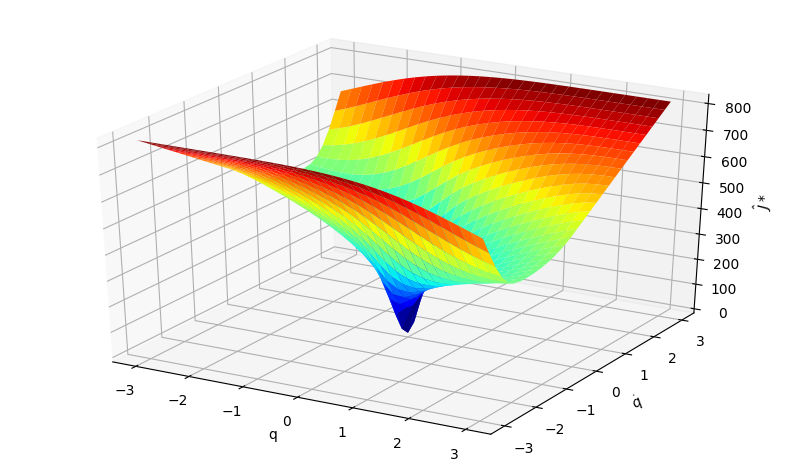

In [ ]:
plot_surface(min_time_states[0, :], min_time_states[1, :], min_time_current_costs, 31)
plt.show()

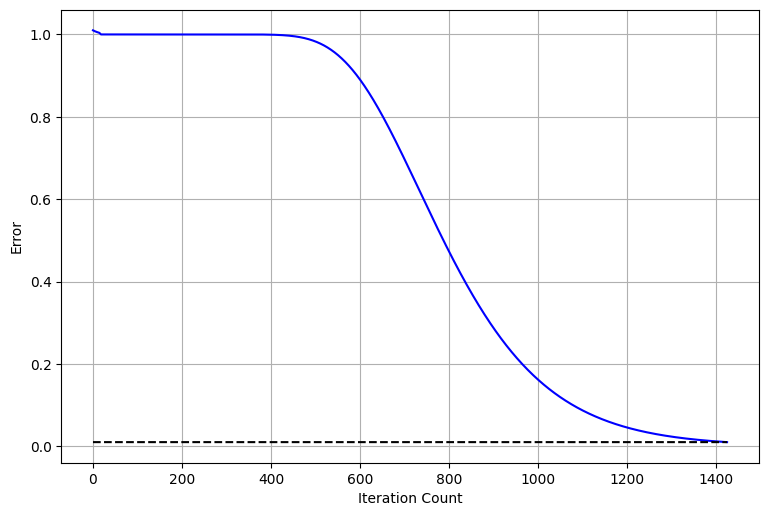

In [ ]:
plot_error_history(min_time_err_history)
plt.show()

# Minimum Quadratic Cost Results

In [ ]:
min_quad_states, min_quad_current_costs, min_quad_err_history = double_integrator_quadratic_regulator(31, plot=False, print_rate=200)

Double Integrator, Quadratic Cost: Iteration = 200, Error = 11.23405744364345
Double Integrator, Quadratic Cost: Iteration = 400, Error = 7.488914159440355
Double Integrator, Quadratic Cost: Iteration = 600, Error = 2.099708198205917
Double Integrator, Quadratic Cost: Iteration = 800, Error = 0.3823567871049818
Double Integrator, Quadratic Cost: Iteration = 1000, Error = 0.0963901070135762
Double Integrator, Quadratic Cost: Iteration = 1200, Error = 0.03999999999999915
Double Integrator, Quadratic Cost: Iteration = 1400, Error = 0.03999999999999915
Double Integrator, Quadratic Cost: Iteration = 1558, Error = 0.009997735822764753


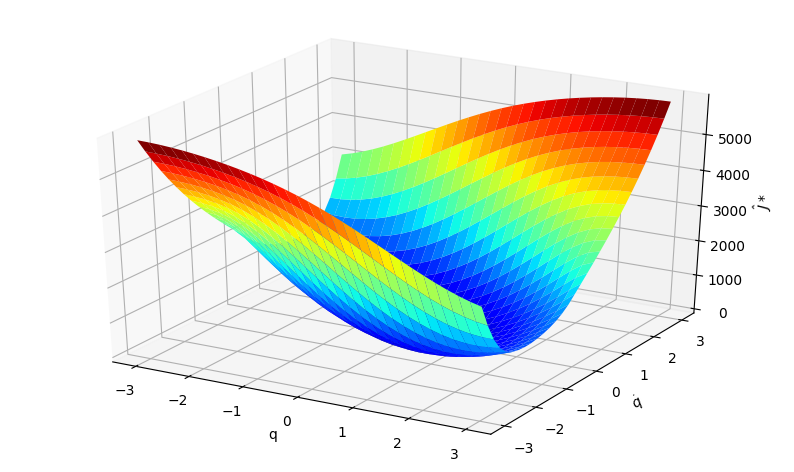

In [ ]:
plot_surface(min_quad_states[0, :], min_quad_states[1, :], min_quad_current_costs, 31)
plt.show()

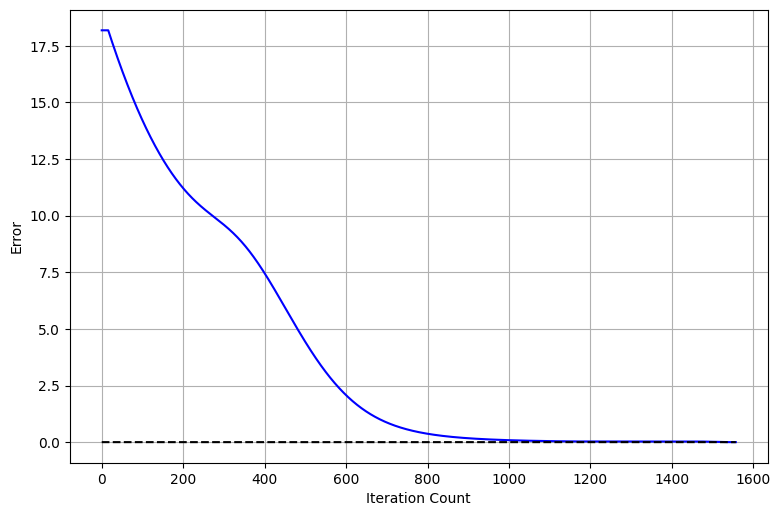

In [ ]:
plot_error_history(min_quad_err_history)
plt.show()